CODE BLOCK: 1

In [1]:
from google.colab import files
files.upload()

Saving model.py to model.py
Saving utils.py to utils (2).py


{'model.py': b"'''\nThis defines the model architecture\n    - 2 Conv2d\n    - MP\n    - 2 Conv2d\n    - MP\n    - 2 linear layers\n'''\n\n\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass Net(nn.Module):\n    #This defines the structure of the NN.\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Sequential(\n                                nn.Conv2d(1, 8, kernel_size=3),\n                                nn.BatchNorm2d(8),\n                                nn.Dropout(0.02),\n                                nn.ReLU()\n\n                              )\n        self.conv2 = nn.Sequential(\n                                nn.Conv2d(8, 16, kernel_size=3),\n                                nn.BatchNorm2d(16),\n                                nn.Dropout(0.02),\n                                nn.ReLU(),\n                                nn.MaxPool2d(kernel_size=2, stride=2)\n                              )\n        self.conv3 = nn.Sequential

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from model import Net
from utils import *

# New section

CODE BLOCK: 2

In [3]:
# CUDA?
#cuda = if torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Available?", device)

CUDA Available? cuda


CODE BLOCK: 3

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 512 # 512 but why ?

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

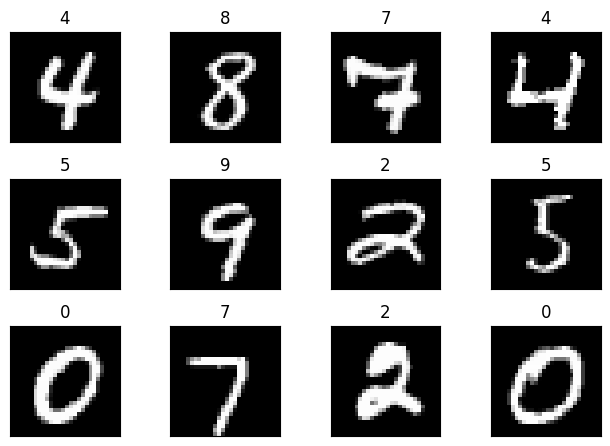

In [6]:
plot_train_samples(train_loader)

CODE BLOCK: 7

CODE BLOCK: 8

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [8]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [9]:
model = Net().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,168
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 32, 10, 10]           4,640
      BatchNorm2d-11           [-1, 32, 10, 10]              64
          Dropout-12           [-1, 32, 10, 10]               0
             ReLU-13           [-1, 32, 10, 10]               0
        MaxPool2d-14             [-1, 3

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.5075 Batch_id=19 Accuracy=44.47: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Test set: Average loss: 2.0254, Accuracy: 11158/60000 (18.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.8810 Batch_id=19 Accuracy=76.81: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Test set: Average loss: 1.1745, Accuracy: 39934/60000 (66.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.5525 Batch_id=19 Accuracy=89.09: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Test set: Average loss: 0.8286, Accuracy: 46259/60000 (77.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.3714 Batch_id=19 Accuracy=93.07: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Test set: Average loss: 0.6918, Accuracy: 48118/60000 (80.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2359 Batch_id=19 Accuracy=94.73: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Test set: Average loss: 0.5213, Accuracy: 51605/60000 (86.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.2528 Batch_id=19 Accuracy=95.74: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Test set: Average loss: 0.4041, Accuracy: 53651/60000 (89.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.2055 Batch_id=19 Accuracy=96.43: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Test set: Average loss: 0.3407, Accuracy: 54889/60000 (91.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1768 Batch_id=19 Accuracy=96.84: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Test set: Average loss: 0.3337, Accuracy: 54552/60000 (90.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1517 Batch_id=19 Accuracy=97.23: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Test set: Average loss: 0.3302, Accuracy: 54440/60000 (90.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1205 Batch_id=19 Accuracy=97.53: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Test set: Average loss: 0.2469, Accuracy: 56261/60000 (93.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1293 Batch_id=19 Accuracy=97.86: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Test set: Average loss: 0.2576, Accuracy: 55866/60000 (93.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1277 Batch_id=19 Accuracy=97.94: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Test set: Average loss: 0.2564, Accuracy: 55795/60000 (92.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1270 Batch_id=19 Accuracy=98.24: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Test set: Average loss: 0.2297, Accuracy: 56222/60000 (93.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0806 Batch_id=19 Accuracy=98.36: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Test set: Average loss: 0.2405, Accuracy: 55904/60000 (93.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0822 Batch_id=19 Accuracy=98.49: 100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


Test set: Average loss: 0.2143, Accuracy: 56332/60000 (93.89%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0539 Batch_id=19 Accuracy=98.75: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Test set: Average loss: 0.1947, Accuracy: 56790/60000 (94.65%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0736 Batch_id=19 Accuracy=98.68: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


Test set: Average loss: 0.1870, Accuracy: 57069/60000 (95.11%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.1044 Batch_id=19 Accuracy=98.70: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Test set: Average loss: 0.1861, Accuracy: 57019/60000 (95.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0811 Batch_id=19 Accuracy=98.72: 100%|██████████| 20/20 [00:02<00:00,  7.48it/s]


Test set: Average loss: 0.1883, Accuracy: 56966/60000 (94.94%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0668 Batch_id=19 Accuracy=98.76: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Test set: Average loss: 0.1864, Accuracy: 57032/60000 (95.05%)

Adjusting learning rate of group 0 to 1.0000e-03.


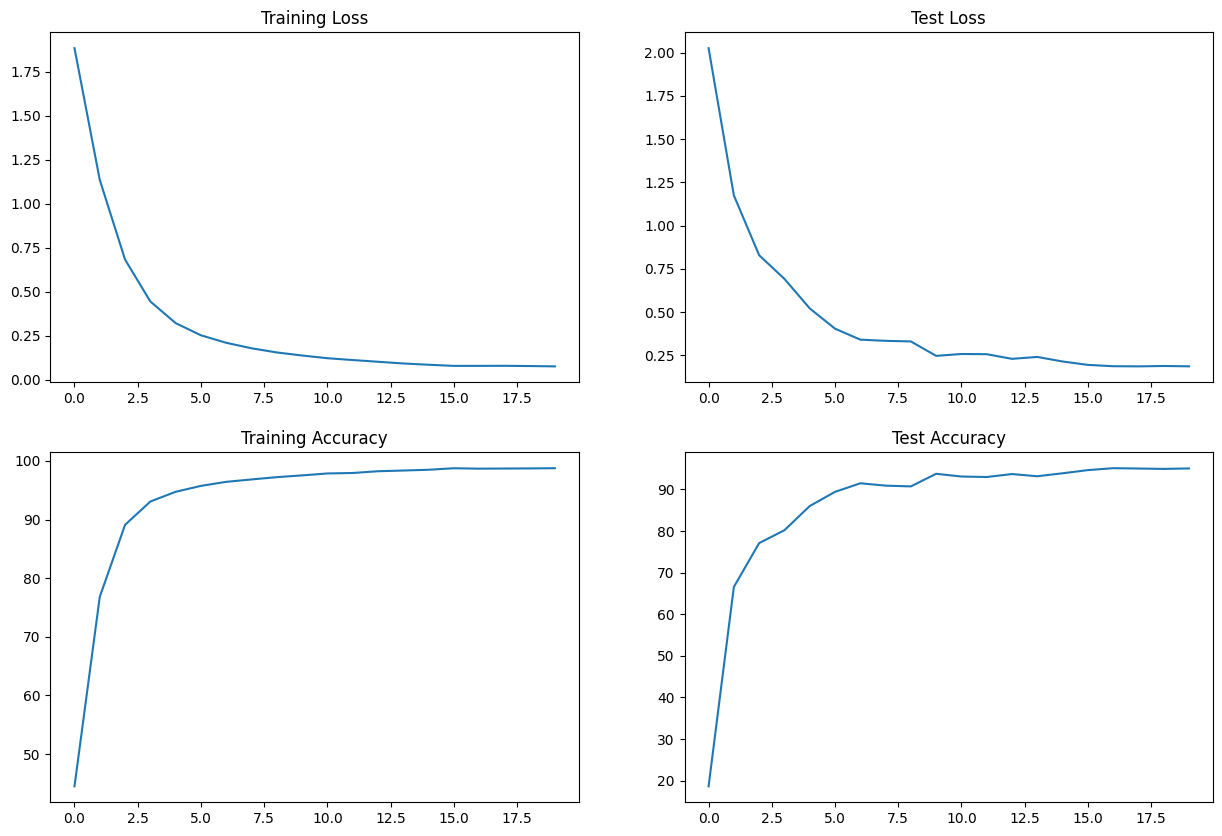

In [11]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,168
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 32, 10, 10]           4,640
      BatchNorm2d-11           [-1, 32, 10, 10]              64
          Dropout-12           [-1, 32, 10, 10]               0
    